In [1]:
# Imports
import os
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix

### Data load

In [2]:
X_train = np.load('data/RXNFP/X_train_RXNFP.npy')
X_test = np.load('data/RXNFP/X_test_RXNFP.npy')
X_val = np.load('data/RXNFP/X_val_RXNFP.npy')

In [3]:
train = pd.read_csv('data/train.csv', delimiter=',')
test = pd.read_csv('data/test.csv', delimiter=',')
val = pd.read_csv('data/val.csv', delimiter=',')

In [4]:
y_train = train['CLASS-ID'].values
y_test = test['CLASS-ID'].values
y_val = val['CLASS-ID'].values

In [5]:
X_train = np.squeeze(X_train)
X_test = np.squeeze(X_test)
X_val = np.squeeze(X_val)

In [24]:
df_test1nn = pd.read_csv('data/RXNFP/df_test1nn.csv', delimiter=',')

In [13]:
y_pred_test_1nn = np.load('data/RXNFP/y_pred_test_1nn.npy')

### Evaluation

In [10]:
df_class = pd.read_csv('data/className.tsv', sep='\t', encoding='ISO-8859-1')

In [11]:
# Convert multi Class-ID into one
def clean_class_id(row):
    # Split the string by comma and convert to a list
    class_ids = str(row['CLASS-ID']).split(',')
    # Return the first element from the list, ensuring it's an integer
    return int(class_ids[0].strip())

# Apply the function to the 'CLASS-ID' column
df_class['CLASS-ID'] = df_class.apply(clean_class_id, axis=1)
df_class['CLASS-ID'] = df_class['CLASS-ID'].astype(int)

In [26]:
df_test1nn

,CLASS-ID,precision,recall,f1-score,test_support,train_support,TRANSFORM_NAME,TRANSFORM_ID
0,1085,0.996836,0.996996,0.996916,24966,185024,"Suzuki coupling, Suzuki-Miyaura Cross-Coupling","(ARCOUPLG)4.1.B, (AVNAMEDR)Suzuki-Miyaura"
1,432,0.975303,0.980808,0.978048,21259,164914,N-alkylation of alkylamines,(AG2ALKN)1.1.2
2,1016,0.991660,0.989102,0.990379,15507,113635,hydrolysis of carboxylic esters,(AQCLEAV1)1.1
3,60,0.998389,0.997228,0.997808,11185,85921,reduction of C-NO2 to C-NH2,(AAREDUCT)A.1
4,433,0.943528,0.946722,0.945122,7977,60554,"N-alkylation of benzenoid amines, anilines",(AG2ALKN)1.1.3
...,...,...,...,...,...,...,...,...
1294,1267,1.000000,1.000000,1.000000,1,8,Brackeen Imidazole Synthesis,(AVNAMEDR)Brackeen
1295,1800,1.000000,0.800000,0.888889,5,8,Shestakov Hydrazino Acid Synthesis,(AVNAMEDR)Shestakov
1296,500,0.000000,0.000000,0.000000,1,7,"O-propargylation of N-hydroxy amides, includin...",(AG2ALKO)2.4.1
1297,1622,0.500000,1.000000,0.666667,1,7,ListMacMillan Hydrogenation,(AVNAMEDR)List-MacMillan


In [27]:
df_test1nn['SUPER_TRANSFORM_ID'] = df_test1nn['TRANSFORM_ID'].str.extract(r'\((.*?)\)')

In [29]:
def weighted_mean(values, weights):
    return (values * weights).sum() / weights.sum()

In [30]:
grouped = df_test1nn.groupby('SUPER_TRANSFORM_ID')

grouped_metrics = grouped.apply(lambda x: pd.Series({
    'weighted_precision': weighted_mean(x['precision'], x['test_support']),
    'weighted_recall': weighted_mean(x['recall'], x['test_support']),
    'weighted_f1-score': weighted_mean(x['f1-score'], x['test_support']),
    'total_test_support': x['test_support'].sum(),
    'total_train_support': x['train_support'].sum(),
    'class_count': len(x)
}))

In [31]:
grouped_metrics.sort_values(by=['weighted_f1-score'])

,weighted_precision,weighted_recall,weighted_f1-score,total_test_support,total_train_support,class_count
SUPER_TRANSFORM_ID,,,,,,
ATRNGSIZ,0.852152,0.800000,0.813344,125.0,995.0,14.0
AG2ALKC,0.871191,0.873437,0.870614,3840.0,26254.0,58.0
AG3ACYS,0.878327,0.874490,0.875278,980.0,7197.0,24.0
AG6NITRA,0.929474,0.872852,0.897189,291.0,2241.0,9.0
ABOXIDAT,0.901625,0.895660,0.898331,24813.0,175151.0,105.0
ASARYNES,0.890303,0.981818,0.918090,55.0,399.0,14.0
AG4BORYL,0.924151,0.916145,0.918870,799.0,5708.0,10.0
AG8PHOS,0.921455,0.921627,0.921094,3024.0,23495.0,25.0
AFCYCLIZ,0.921910,0.922255,0.921253,4026.0,31313.0,30.0


In [32]:
# Calculate macro average for precision, recall, and f1-score
macro_precision2 = df_test1nn['precision'].mean()
macro_recall2 = df_test1nn['recall'].mean()
macro_f12 = df_test1nn['f1-score'].mean()

# Calculate weighted average for precision, recall, and f1-score
weighted_precision2 = (df_test1nn['precision'] * df_test1nn['test_support']).sum() / df_test1nn['test_support'].sum()
weighted_recall2 = (df_test1nn['recall'] * df_test1nn['test_support']).sum() / df_test1nn['test_support'].sum()
weighted_f12 = (df_test1nn['f1-score'] * df_test1nn['test_support']).sum() / df_test1nn['test_support'].sum()

In [33]:
output1 = f"""
Macro-averages:
- Precision: {macro_precision2:.4f}
- Recall: {macro_recall2:.4f}
- F1-score: {macro_f12:.4f}

Weighted-averages:
- Precision: {weighted_precision2:.4f}
- Recall: {weighted_recall2:.4f}
- F1-score: {weighted_f12:.4f}
"""

In [34]:
print(f'Accuracy: {accuracy_score(y_test, y_pred_test1nn)}')

Accuracy: 0.9579758773918563


In [35]:
print(output1)


Macro-averages:
- Precision: 0.8747
- Recall: 0.8642
- F1-score: 0.8625

Weighted-averages:
- Precision: 0.9581
- Recall: 0.9580
- F1-score: 0.9578



In [36]:
summary_stats = df_test1nn[["precision", "recall", "f1-score", "test_support", "train_support"]].describe()
summary_stats

,precision,recall,f1-score,test_support,train_support
count,1299.000000,1299.000000,1299.000000,1299.000000,1299.000000
mean,0.874655,0.864184,0.862474,254.665127,1851.890685
std,0.192682,0.205445,0.192046,1212.528218,9034.637418
min,0.000000,0.000000,0.000000,1.000000,7.000000
25%,0.833333,0.818182,0.815571,6.000000,39.000000
50%,0.945946,0.950980,0.933333,24.000000,160.000000
75%,1.000000,1.000000,0.983607,110.500000,811.000000
max,1.000000,1.000000,1.000000,24966.000000,185024.000000


In [37]:
low_f1_reactions = df_test1nn[df_test1nn['f1-score'] < df_test1nn['f1-score'].quantile(0.25)].head(10)

### Wrong predict evaluation in details

In [38]:
class_to_transform_id = pd.Series(df_class['TRANSFORM_ID'].values,index=df_class['CLASS-ID']).to_dict()

In [39]:
y_pred_flattened = y_pred_test1nn.flatten() 

In [40]:
mismatches = y_pred_flattened != y_test

full_comparison_df = pd.DataFrame({
    'CLASS-ID': y_test,
    'CLASS-ID-predict': y_pred_flattened,
    'Misclassified': mismatches
})

misclassified_df = full_comparison_df[full_comparison_df['Misclassified'] == True].sort_values(by=['CLASS-ID', 'CLASS-ID-predict'])

In [41]:
counts = misclassified_df.groupby(['CLASS-ID', 'CLASS-ID-predict']).size().reset_index(name='Count')
top_counts = (counts.sort_values(by=['CLASS-ID', 'Count'], ascending=[True, False])
             .groupby('CLASS-ID')
             .head(3))

In [49]:
reshaped_df = pd.DataFrame()
rows = []
for i, group in top_counts.groupby('CLASS-ID'):
    reshaped_row = {'CLASS-ID': i}
    for j, (index, row) in enumerate(group.iterrows(), start=1):
        reshaped_row[f'Top{j}_CLASS-ID-predict'] = row['CLASS-ID-predict']
        reshaped_row[f'Top{j}_Count'] = row['Count']
    rows.append(reshaped_row)

# Use concat instead of append
reshaped_df = pd.concat([reshaped_df, pd.DataFrame(rows)], ignore_index=True)

# Process columns as needed
reshaped_df = reshaped_df[['CLASS-ID'] + [col for col in reshaped_df.columns if col != 'CLASS-ID']].fillna(0).astype(int)

In [50]:
reshaped_df['Top1_MISTRANSFORM_ID'] = reshaped_df['Top1_CLASS-ID-predict'].map(class_to_transform_id)
reshaped_df['Top2_MISTRANSFORM_ID'] = reshaped_df['Top2_CLASS-ID-predict'].map(class_to_transform_id)
reshaped_df['Top3_MISTRANSFORM_ID'] = reshaped_df['Top3_CLASS-ID-predict'].map(class_to_transform_id)

In [51]:
df_low = pd.merge(low_f1_reactions, reshaped_df[['CLASS-ID', 'Top1_MISTRANSFORM_ID', 'Top1_Count', 'Top2_MISTRANSFORM_ID', 'Top2_Count', 'Top3_MISTRANSFORM_ID', 'Top3_Count']], on='CLASS-ID', how='left')

In [52]:
df_low

,CLASS-ID,precision,recall,f1-score,test_support,train_support,TRANSFORM_NAME,TRANSFORM_ID,SUPER_TRANSFORM_ID,Top1_MISTRANSFORM_ID,Top1_Count,Top2_MISTRANSFORM_ID,Top2_Count,Top3_MISTRANSFORM_ID,Top3_Count
0,109,0.813115,0.753341,0.782088,1646,12611,"Dess-Martin ketone synthesis, Dess-Martin oxid...","(ABOXIDAT)5.2.3, (AVNAMEDR)Dess-Martin1.2",ABOXIDAT,(AVNAMEDR)Corey-Suggs,250,"(ABOXIDAT)5.2.1, (AVNAMEDR)Swern1.2",123,"(ABOXIDAT)5.2.2, (AVNAMEDR)Jones1.1.2",10
1,1331,0.652981,0.696461,0.674020,1667,12096,Corey-Suggs Reagent,(AVNAMEDR)Corey-Suggs,AVNAMEDR,"(ABOXIDAT)5.2.3, (AVNAMEDR)Dess-Martin1.2",156,"(ABOXIDAT)5.1.3, (AVNAMEDR)Dess-Martin1.1",124,"(ABOXIDAT)5.1.1, (AVNAMEDR)Swern1.1",108
2,99,0.747285,0.714187,0.730361,1445,10979,"Dess-Martin aldehyde synthesis, Dess-Martin ox...","(ABOXIDAT)5.1.3, (AVNAMEDR)Dess-Martin1.1",ABOXIDAT,"(ABOXIDAT)5.1.1, (AVNAMEDR)Swern1.1",244,(AVNAMEDR)Corey-Suggs,146,"(ABOXIDAT)5.1.4, (AVNAMEDR)Parikh-Doering1.1",15
3,864,0.804766,0.795593,0.800153,1316,10486,condensation of heteroaryl aldehydes with hydr...,(AHCONDEN)7.1.3,AHCONDEN,(AHCONDEN)7.1.2,261,(AHCONDEN)7.1.1,7,"(AVNAMEDR)Aldol1.2, (AVNAMEDR)Claisen5, (AVNAM...",1
4,97,0.640610,0.687117,0.663049,978,7239,"Swern aldehyde synthesis, Swern oxidation of a...","(ABOXIDAT)5.1.1, (AVNAMEDR)Swern1.1",ABOXIDAT,"(ABOXIDAT)5.1.3, (AVNAMEDR)Dess-Martin1.1",197,(AVNAMEDR)Corey-Suggs,89,"(ABOXIDAT)5.1.4, (AVNAMEDR)Parikh-Doering1.1",13
5,868,0.753982,0.762075,0.758007,559,4429,condensation of heteroaryl alkyl ketones with ...,(AHCONDEN)7.2.4,AHCONDEN,(AHCONDEN)7.2.2,101,(AHCONDEN)7.2.1,29,(AHCONDEN)7.2.5,2
6,79,0.775468,0.790254,0.782791,472,3686,"osmylation of alkenes to 1,2-diols",(ABOXIDAT)2.1.1,ABOXIDAT,(ABOXIDAT)2.1.2,44,(ABOXIDAT)2.1.3,35,(ABOXIDAT)2.1.4,9
7,107,0.532584,0.539863,0.536199,439,3377,"Swern oxidation of alcohols to ketones, Swern ...","(ABOXIDAT)5.2.1, (AVNAMEDR)Swern1.2",ABOXIDAT,"(ABOXIDAT)5.2.3, (AVNAMEDR)Dess-Martin1.2",100,(AVNAMEDR)Corey-Suggs,89,"(ABOXIDAT)5.2.2, (AVNAMEDR)Jones1.1.2",7
8,312,0.794702,0.776699,0.785597,309,2458,"intramolecular Diels-Alder cycloaddition, intr...","(AFCYCLIZ)1.1.3, (AVNAMEDR)Diels-Alder1.2.1",AFCYCLIZ,(AVNAMEDR)Diels-Alder1.1.1,31,(AFCYCLIZ)3.2.2,5,(AFCYCLIZ)1.1.6,3
9,875,0.753191,0.804545,0.778022,220,1732,condensation of aryl alkyl ketones with hydrox...,(AHCONDEN)8.2.2,AHCONDEN,(AHCONDEN)8.2.1,18,(AHCONDEN)8.2.4,15,(AHCONDEN)8.2.5,6


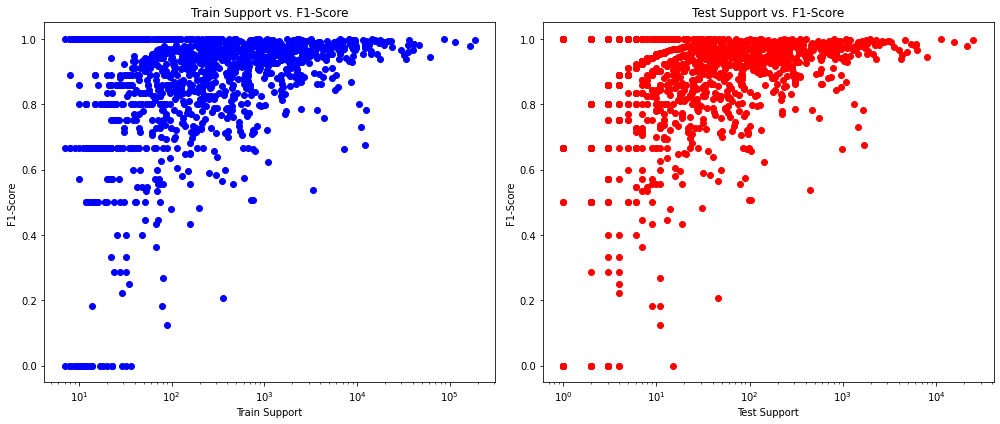

In [53]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.scatter(df_test1nn['train_support'], df_test1nn['f1-score'], color='blue')
ax1.set_title('Train Support vs. F1-Score')
ax1.set_xlabel('Train Support')
ax1.set_ylabel('F1-Score')
ax1.set_xscale('log')  # Set x-axis to log scale

ax2.scatter(df_test1nn['test_support'], df_test1nn['f1-score'], color='red')
ax2.set_title('Test Support vs. F1-Score')
ax2.set_xlabel('Test Support')
ax2.set_ylabel('F1-Score')
ax2.set_xscale('log')  # Set x-axis to log scale

plt.tight_layout()
plt.show()

### Manual test(Will be improved)

In [270]:
Manually_input = 'CC(=O)OC(\\C=C\\c1ccccc1)C#N>>CC(=O)OC(CC(=O)c1ccccc1)C#N'